In [19]:
#importing libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import glob, os
from numpy import dstack

# Data Scaling
from sklearn.preprocessing import StandardScaler
from sklearn.base import TransformerMixin



import keras
import tensorflow as tf
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense
# from tensorflow.keras.layers import LSTM
# from tensorflow.keras.layers import Dropout

# from tensorflow.keras.utils import to_categorical
from sklearn.metrics import confusion_matrix

import seaborn as sns
from matplotlib.pyplot import figure

print('libraries have imported ')

libraries have imported 


# Reading Activities Samples

Data Preparation using standard method for LSTM.

In [20]:
path = "/Users/loriyaharsh/Desktop/HARSH/UGRP/Human motion detection /Experiment- 3/Data" #set path
os.chdir(path) 
results = pd.DataFrame([]) # creating empty datafeame 
list_file = glob.glob("*.csv") #lisiting all the csv file samples
print(list_file)

# function for reading CSV files 
def reading_file(activity_csv):     
    results = []
    for i in range(len(activity_csv)):
        df = pd.read_csv(activity_csv[i])
        results.append(df.values)

    
    # print(results)  
    return results


empty_csv = [i for i in list_file if i.startswith('Empty')] #list for empty csv files 
lying_csv = [i for i in list_file if i.startswith('Lying')] #list for lying csv files 
sitting_csv = [i for i in list_file if i.startswith('Sitting')] #list for sitting csv files 
standing_csv = [i for i in list_file if i.startswith('Standing')] #list for satnding csv files 
walking_csv = [i for i in list_file if i.startswith('Walking')] #list for walking csv files 

#calling reading_file function  
empty = reading_file(empty_csv) 
lying = reading_file(lying_csv)
sitting = reading_file(sitting_csv)
standing = reading_file(standing_csv)
walking = reading_file(walking_csv)
# print(empty)

#function for labeling the samples 
def label(activity, label):
    list_y = []
    for i in range(len(activity)):
        list_y.append(label)
    # print(list_y)
    return np.array(list_y).reshape(-1, 1) 
    
walking_label = label(walking, 'walking') 
empty_label = label(empty, 'empty') 
lying_label = label(lying, 'lying') 
sitting_label = label(sitting, 'sitting') 
standing_label = label(standing, 'standing') 


#concatenate all the samples into one np array 
array_tuple = (empty, lying, sitting,standing, walking)
data_X = np.vstack(array_tuple)

#concatenate all the label into one array 
label_tuple = (empty_label, lying_label, sitting_label,standing_label,  walking_label)
data_y = np.vstack(label_tuple)

#randomize the sample 
from sklearn.utils import shuffle
data_X, data_y= shuffle(data_X, data_y)

['Sitting_Amp_34.csv', 'Empty_Amp_183.csv', 'Walking_48.csv', 'Empty_Amp_197.csv', 'Lying_Amp_15.csv', 'Sitting_Amp_20.csv', 'Walking_60.csv', 'Lying_Amp_282.csv', 'Lying_Amp_296.csv', 'Walking_74.csv', 'Lying_Amp_29.csv', 'Empty_Amp_140.csv', 'Lying_Amp_269.csv', 'Empty_Amp_154.csv', 'Walking_4.csv', 'Lying_Amp_241.csv', 'Empty_Amp_21.csv', 'Empty_Amp_35.csv', 'Lying_Amp_255.csv', 'Empty_Amp_168.csv', 'Sitting_Amp_115.csv', 'Walking_117.csv', 'Sitting_Amp_101.csv', 'Walking_103.csv', 'Sitting_Amp_129.csv', 'Empty_Amp_236.csv', 'Standing_Amp_128.csv', 'Empty_Amp_222.csv', 'Standing_Amp_100.csv', 'Lying_Amp_137.csv', 'Standing_Amp_114.csv', 'Lying_Amp_123.csv', 'Lying_Amp_309.csv', 'Standing_Amp_13.csv', 'Lying_Amp_5.csv', 'Lying_Amp_335.csv', 'Lying_Amp_321.csv', 'Lying_Amp_320.csv', 'Lying_Amp_4.csv', 'Lying_Amp_334.csv', 'Standing_Amp_12.csv', 'Lying_Amp_308.csv', 'Lying_Amp_122.csv', 'Standing_Amp_115.csv', 'Lying_Amp_136.csv', 'Standing_Amp_101.csv', 'Empty_Amp_223.csv', 'Standing_

 # Training and Testing Split

In [21]:
# training and testing 
from sklearn.model_selection import train_test_split
X = data_X
y = data_y

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.20, random_state=42)

# Data Standradization

In [22]:
class Standard_Scaler(TransformerMixin):
    def __init__(self, **kwargs):
        self._scaler = StandardScaler(copy=True, **kwargs)
        self._orig_shape = None

    def fit(self, X, **kwargs):
        X = np.array(X)
        # Save the original shape to reshape the flattened X later
        # back to its original shape
        if len(X.shape) > 1:
            self._orig_shape = X.shape[1:]
        X = self._flatten(X)
        self._scaler.fit(X, **kwargs)
        return self

    def transform(self, X, **kwargs):
        X = np.array(X)
        X = self._flatten(X)
        X = self._scaler.transform(X, **kwargs)
        X = self._reshape(X)
        return X

    def _flatten(self, X):
        # Reshape X to <= 2 dimensions
        if len(X.shape) > 2:
            n_dims = np.prod(self._orig_shape)
            X = X.reshape(-1, n_dims)
        return X

    def _reshape(self, X):
        # Reshape X back to it's original shape
        if len(X.shape) >= 2:
            X = X.reshape(-1, *self._orig_shape)
        return X

sc = Standard_Scaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform (X_test)

# one-hot encoding for classes 

In [23]:
#Encode categorical features (Activity Names) as a one-hot numeric array.

from sklearn.preprocessing import OneHotEncoder
en = OneHotEncoder()
y_train_en = OneHotEncoder().fit_transform(y_train.reshape(-1, 1)).toarray()

y_test_en = OneHotEncoder().fit_transform(y_test.reshape(-1, 1)).toarray()

# LSTM Model Design 

In [24]:
activity_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(units=64, input_shape= X_train[-2,:].shape),#timestep and number of columns((500, 256)
    tf.keras.layers.Dropout(rate=0.5), #for overfitting
    tf.keras.layers.Dense(units=32, activation='relu'), 
    tf.keras.layers.Dense(y_train_en.shape[1], activation='softmax')#Softmax converts a real vector to a vector of 
                                                                  #categorical probabilities
                                                                    # output shape (number of classes) 
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch / 20))

opt = keras.optimizers.Adam(lr=1e-8)

activity_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

# print(y_train_en.shape[1])
model_history = activity_model.fit(X_train, y_train_en, epochs= 80, validation_split=0.2,  batch_size=16, callbacks = [lr_schedule])

Epoch 1/80
48/48 [==============================] - 8s 153ms/step - loss: 1.6914 - accuracy: 0.2031 - val_loss: 1.6443 - val_accuracy: 0.2135 - lr: 1.0000e-08
Epoch 2/80
48/48 [==============================] - 7s 146ms/step - loss: 1.7059 - accuracy: 0.1901 - val_loss: 1.6443 - val_accuracy: 0.2135 - lr: 1.1220e-08
Epoch 3/80
48/48 [==============================] - 7s 145ms/step - loss: 1.6970 - accuracy: 0.2018 - val_loss: 1.6443 - val_accuracy: 0.2135 - lr: 1.2589e-08
Epoch 4/80
48/48 [==============================] - 7s 146ms/step - loss: 1.6985 - accuracy: 0.2083 - val_loss: 1.6442 - val_accuracy: 0.2135 - lr: 1.4125e-08
Epoch 5/80
48/48 [==============================] - 7s 146ms/step - loss: 1.6965 - accuracy: 0.2096 - val_loss: 1.6442 - val_accuracy: 0.2135 - lr: 1.5849e-08
Epoch 6/80
48/48 [==============================] - 7s 152ms/step - loss: 1.6992 - accuracy: 0.1836 - val_loss: 1.6442 - val_accuracy: 0.2135 - lr: 1.7783e-08
Epoch 7/80
48/48 [============================

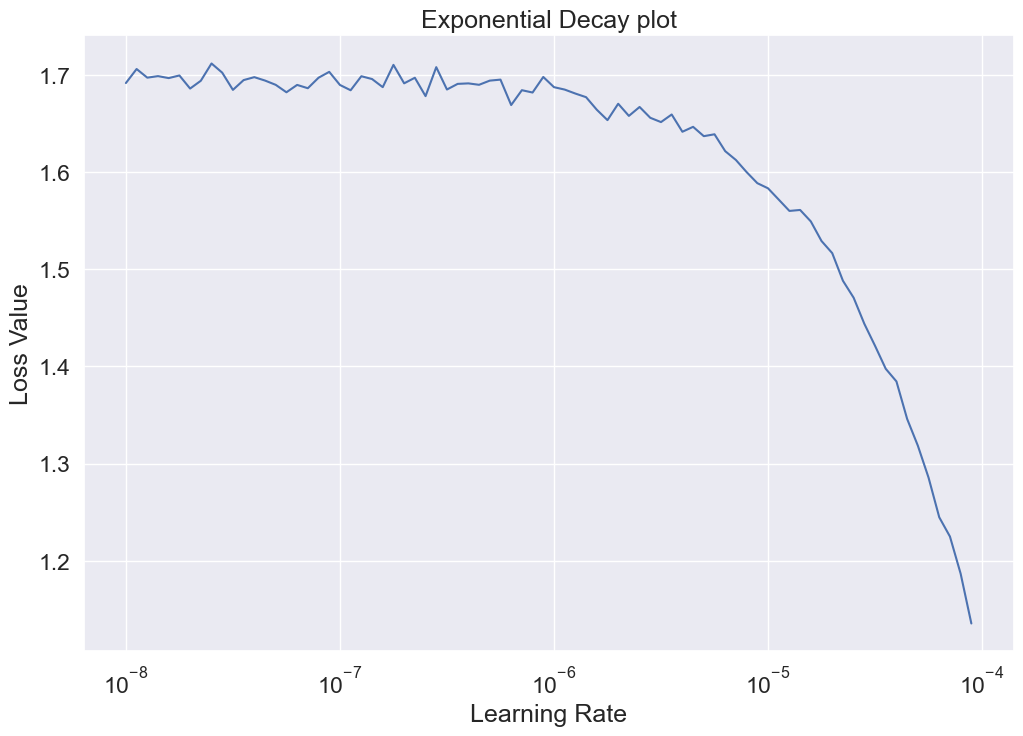

In [25]:
# Exponential Decay Plot
figure(figsize=(12, 8))
plt.semilogx(model_history.history["lr"], np.array(model_history.history["loss"]))
sns.set(font_scale=1.5)
plt.ylabel('Loss Value')
plt.xlabel('Learning Rate')
plt.title('Exponential Decay plot')
plt.show()

# Model traing after choosing best learning rate 

In [26]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('val_accuracy')>0.98):
            print("\nAccuracy has reached to threshold (98%) so stopping training!")
            self.model.stop_training = True

callbacks = myCallback()

earlystopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10)

model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(units=64, input_shape= X_train[-2,:].shape),#timestep and number of columns((500, 256)
    tf.keras.layers.Dropout(rate=0.5), #for overfitting
    tf.keras.layers.Dense(units=32, activation='relu'), 
    tf.keras.layers.Dense(y_train_en.shape[1], activation='softmax'),#Softmax converts a real vector to a vector of 
                                                                  #categorical probabilities
                                                                    # output shape (number of classes) 
])
opt = keras.optimizers.Adam(learning_rate=1e-3)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])




## Model Summary Plot

In [27]:
from keras.utils import plot_model
plot_model(model, to_file='model_plot_1.png', show_shapes=True, show_layer_names=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


## LSTM Model Training 

In [28]:
history = model.fit(X_train, y_train_en, epochs= 80, batch_size=16, validation_split = 0.2, callbacks = [callbacks, earlystopping])

Epoch 1/80
48/48 [==============================] - 8s 156ms/step - loss: 1.2412 - accuracy: 0.5130 - val_loss: 0.8931 - val_accuracy: 0.6406
Epoch 2/80
48/48 [==============================] - 7s 148ms/step - loss: 0.7118 - accuracy: 0.7734 - val_loss: 0.5521 - val_accuracy: 0.8073
Epoch 3/80
48/48 [==============================] - 7s 148ms/step - loss: 0.3974 - accuracy: 0.8828 - val_loss: 0.3511 - val_accuracy: 0.8854
Epoch 4/80
48/48 [==============================] - 7s 147ms/step - loss: 0.2379 - accuracy: 0.9258 - val_loss: 0.2933 - val_accuracy: 0.8802
Epoch 5/80
48/48 [==============================] - 7s 146ms/step - loss: 0.1552 - accuracy: 0.9518 - val_loss: 0.2691 - val_accuracy: 0.9062
Epoch 6/80
48/48 [==============================] - 7s 148ms/step - loss: 0.1157 - accuracy: 0.9701 - val_loss: 0.3080 - val_accuracy: 0.8854
Epoch 7/80
48/48 [==============================] - 7s 147ms/step - loss: 0.0811 - accuracy: 0.9753 - val_loss: 0.1701 - val_accuracy: 0.9583
Epoch 

## Model Evaluation

In [29]:
y_pred = model.predict(X_test) #prediction on test data set

model.evaluate(X_test, y_test_en)

8/8 [==============================] - 1s 76ms/step - loss: 0.1364 - accuracy: 0.9793


[0.136374831199646, 0.9792531132698059]

# Model History plot

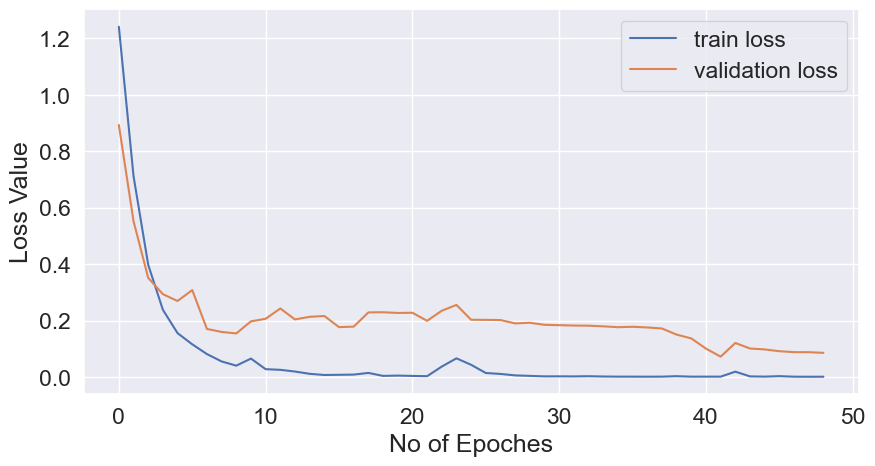

In [30]:
# plot history
figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.ylabel('Loss Value')
plt.xlabel('No of Epoches')
plt.legend()
plt.show()

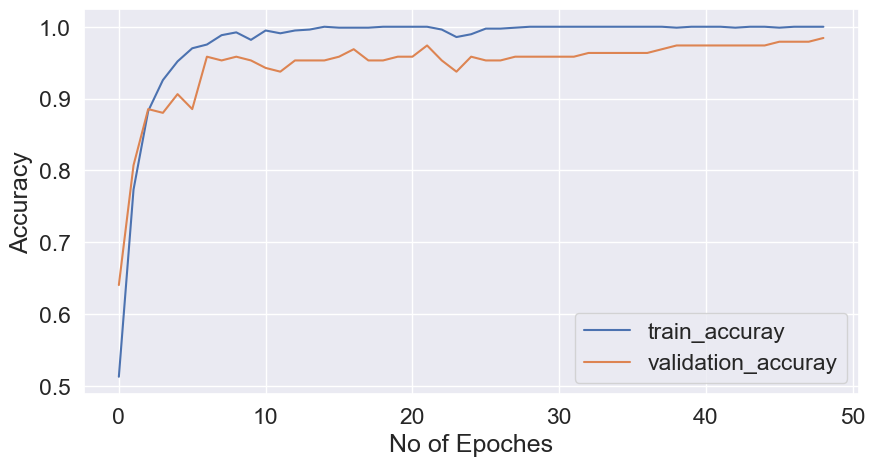

In [31]:
# plot history
figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='train_accuray')
plt.plot(history.history['val_accuracy'], label='validation_accuray')
plt.ylabel('Accuracy')
plt.xlabel('No of Epoches')
plt.legend()
plt.show()

# Confusion Matrix 

In [32]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(np.argmax(y_test_en, axis=1), np.argmax(y_pred, axis=1))
index = ['Empty', 'Lying', 'Sitting','Standing','Walking']  
columns = ['Empty', 'Lying', 'Sitting','Standing','Walking']  
df_cm = pd.DataFrame(confusion_matrix,columns,index) 

Text(0.5, 16.156249999999993, 'Predicted Activities')

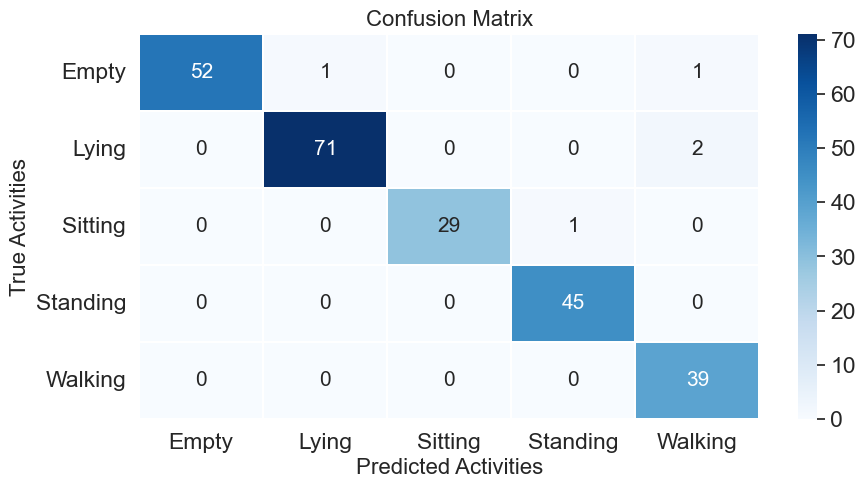

In [33]:
sns.set(font_scale=1.5)
figure(figsize=(10, 5))
sns.heatmap(df_cm, annot=True, cmap='Blues', linewidths=0.2,annot_kws={"fontsize":15})
plt.title("Confusion Matrix", fontsize=16)
plt.ylabel('True Activities', fontsize=16)
plt.xlabel('Predicted Activities', fontsize=16)

In [34]:
# Classification Report

In [35]:
from sklearn.metrics import classification_report
target_names = ['Empty', 'Lying', 'Sitting','Standing','Walking']
print(classification_report(np.argmax(y_test_en, axis=1), np.argmax(y_pred, axis=1), target_names=target_names)) 

              precision    recall  f1-score   support

       Empty       1.00      0.96      0.98        54
       Lying       0.99      0.97      0.98        73
     Sitting       1.00      0.97      0.98        30
    Standing       0.98      1.00      0.99        45
     Walking       0.93      1.00      0.96        39

    accuracy                           0.98       241
   macro avg       0.98      0.98      0.98       241
weighted avg       0.98      0.98      0.98       241

